# Image Generation with AutoEncoders

In [1]:
from data import CelebADataset, PARTITIONS
from models import VAE, GAN
from tensorflow.keras.optimizers.legacy import Adam
import plotly.graph_objects as go 
from IPython.display import HTML
from utils import plot_history, plot_embeds
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt 
import plotly.io as pio 
pio.renderers.default = 'notebook_connected'

2024-05-26 17:29:38.692831: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 17:29:38.754870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 17:29:38.754906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 17:29:38.756306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 17:29:38.766020: I tensorflow/core/platform/cpu_feature_guar

## Table of Contents 

1. [Data preprocessing](#data-preprocessing)
2. [Baselines](#baselines)
    - [Variational AutoEncoder](#variational-autoencoder)
    - [Wasserstein GAN with Gradient Penalty](#wasserstein-gan-with-gradient-penalty)
3. [Experiments and Variations in the Architecture](#experiments-and-variations-in-the-architecture)
4. [Results](#results)
5. [Exploring the latent space](#exploring-the-latent-space)
    - [Latent representations from VAE](#latent-representations-from-vae)
    - [Latent representations from WGAN-GP](#latent-representations-from-wgan-gp)
6. [Comparative Analysis](#comparative-analysis)
    - [Analysis of the VAE](#analysis-of-the-variational-autoencoder-vae)
    - [Analysis of the WGAN-GP](#analysis-of-the-wgan-with-gradient-penalty)
7. [Conclusion](#conclusion)

## Data preprocessing

We followed the CelebA dataset [official split](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to create a train (80%), validation (10%) and test (10%) subsets. In order to create the same split, the script [data.py](data.py) automatically prepares the dataset subfolders to load and train our models (it is required to previously download the [archive.zip](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) from Kaggle).

In [2]:
# !python3 data.py
train, val, test = map(CelebADataset, ('train', 'val', 'test'))
print(f'Number of train samples: {len(train)}')
print(f'Number of validation samples: {len(val)}')
print(f'Number of test samples: {len(test)}')

Number of train samples: 162770
Number of validation samples: 19867
Number of test samples: 19962


As detailed in the class notebooks, we used two types of normalization methods: in the Variational AutoEncoder (see [vae.py](models/vae.py)) the input images are scaled in the range $[0,1]$ (thus the final activation function is a sigmoid), while the GAN model accepts images in the range $[-1,1]$ and the generator module takes an hyperbolic tangent activation function. For these exercises, we used a resolution of $64\times 64$ to generate RGB images.


## Baselines



### Variational AutoEncoder 

Our first baseline for image generation is the Variational AutoEncoder ([Pu et al., 2016](https://proceedings.neurips.cc/paper/2016/file/eb86d510361fc23b59f18c1bc9802cc6-Paper.pdf)). The implementation details can be consulted in the script [vae.py](models/vae.py). The VAE model follows an encoder-decoder architecture: the encoder module ($\mathcal{E}:\mathbb{R}^{h\times w \times 3}\to\mathbb{R}^{d_\text{vae}}$) compreses an input image through multiple convolutional layers to summarize the visual information in a $d_\text{vae}$-dimensional latent vector, while the decoder module ($\mathcal{D}:\mathbb{R}^{d_\text{vae}}\to\mathbb{R}^{h\times w \times 3}$) tries to generate again the input image from the latent vector. Thus, the VAE is trained to summarize visual features in a lower dimensional space and is expected to recover the original distribution from compressed information. 

The class `VAE` accepts the following hyperparameters:

- `img_size`: Image dimensions to feed the VAE. In this case, we used RGB images of dimension $128\times 128$.
- `hidden_size`: Dimension of the latent space. 
- `pool`: If `strides`, it uses doube-strides as a pooling method. If `dilation`, it uses a dilation rate of 2 followed by a max-pooling or up-sampling of factor 2.
- `residual`: Whether to use residual blocks.

The default configuration (used in class notebooks) uses a latent space of dimension $d_h = 200$ with double-strides and no residual nor skip connections:

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
vae = VAE(CelebADataset.IMG_SIZE, hidden_size=200, pool='strides', residual=False)

Instructions for updating:
Colocations handled automatically by placer.


2024-05-25 19:53:39.291828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-05-25 19:53:39.291939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22324 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-05-25 19:53:39.431569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-25 19:53:39.878991: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_54/kernel/Assign' id:3449 op device:{requested: '', assigned: ''} def:{{{node conv2d_54/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_54/kernel, conv2d_54/kernel/Initializer/stateless_ra

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder-input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1 (ConvBlock)           (None, 32, 32, 64)           1792      ['encoder-input[0][0]']       
                                                                                                  
 conv2 (ConvBlock)           (None, 16, 16, 128)          73856     ['conv1[0][0]']               
                                                                                                  
 conv3 (ConvBlock)           (None, 8, 8, 256)            295168    ['conv2[0][0]']               
                                                                                            

The `train()` method of the class `VAE` allows fitting the Keras model with the following hyperparameters:

- `train`: CelebA dataset instance with the training set.
- `val`: CelebA dataset instance with the validation set (used to track the losses and FID score).
- `test`: CelebA dataset instance with the evaluation set (used to save the final generated images).
- `path`: Folder to store all the training results.
- `batch_size`: Batch size.
- `epochs`: Number of training epochs. Default to 10.
- `train_patience`: Number of allowed epochs with no training improvement. Defaults to 5.
- `val_patience`: Number of allowed epochs with no validation improvement. Defaults to 5.
- `steps_per_epoch`: Number of batches per epoch. Defaults to 1500.
- `optimizer`: Keras Optimizer. Defaults to Adam with learning rate $\eta=10^{-4}$.


At training and validation time, the Keras API displays the performance of the model in the train and validation set in the following metrics:

- `r_loss`: Defined as the mean squared error between the real and generated image.
- `kl_loss`: Defined as the KL divergence loss in the latent space.
- `fid`: FID score computed with the [InceptionV3](https://keras.io/api/applications/inceptionv3/). Due to our computational limits, at training time we used a split of 500 samples to compute each FID score, resizing the images to $256\times 256$ resolution.

In [5]:
vae_history = vae.train(train, val, test, 'results/vae/', optimizer=Adam(5e-4), epochs=10)

Found 162770 files belonging to 1 classes.
Found 19867 files belonging to 1 classes.


inception:   0%|          | 0/7 [00:00<?, ?it/s]2024-05-25 19:55:34.083549: W tensorflow/c/c_api.cc:305] Operation '{name:'count_4/Assign' id:8339 op device:{requested: '', assigned: ''} def:{{{node count_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_4, count_4/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-25 19:55:39.665010: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:8419 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runnin

Train on 1500 steps, validate on 1500 steps
Epoch 1/10
1498/1500 [============================>.] - ETA: 0s - batch: 748.5000 - size: 1.0000 - loss: 51.4341 - r_loss: 0.0416 - kl_loss: 9.8283

2024-05-25 19:55:47.666929: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:8419 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-25 19:55:50.905796: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder/output/Sigmoid' id:404 op device:{requested: '', assigned: ''} def:{{{node decoder/output/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/output/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1500/1500 [==============================] - 52s 34ms/step - batch: 749.5000 - size: 1.0000 - loss: 51.4278 - r_loss: 0.0416 - kl_loss: 9.8279 - val_loss: 49.0869 - val_r_loss: 0.0396 - val_kl_loss: 9.4988 - fid: 344.8651 - val_fid: 340.8104
Epoch 2/10
1494/1500 [============================>.] - ETA: 0s - batch: 746.5000 - size: 1.0000 - loss: 46.8464 - r_loss: 0.0368 - kl_loss: 10.0383

1500/1500 [==============================] - 33s 22ms/step - batch: 749.5000 - size: 1.0000 - loss: 46.8291 - r_loss: 0.0368 - kl_loss: 10.0352 - val_loss: 43.9121 - val_r_loss: 0.0345 - val_kl_loss: 9.4164 - fid: 342.9133 - val_fid: 344.4112
Epoch 3/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: 43.1762 - r_loss: 0.0333 - kl_loss: 9.9070

1500/1500 [==============================] - 128s 85ms/step - batch: 749.5000 - size: 1.0000 - loss: 43.1689 - r_loss: 0.0333 - kl_loss: 9.9057 - val_loss: 42.1113 - val_r_loss: 0.0327 - val_kl_loss: 9.3717 - fid: 334.2555 - val_fid: 336.4527
Epoch 4/10
1499/1500 [============================>.] - ETA: 0s - batch: 749.0000 - size: 1.0000 - loss: 42.4398 - r_loss: 0.0326 - kl_loss: 9.8759

1500/1500 [==============================] - 51s 34ms/step - batch: 749.5000 - size: 1.0000 - loss: 42.4394 - r_loss: 0.0326 - kl_loss: 9.8765 - val_loss: 41.8278 - val_r_loss: 0.0319 - val_kl_loss: 9.9435 - fid: 335.3972 - val_fid: 338.6935
Epoch 5/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: 42.1898 - r_loss: 0.0322 - kl_loss: 9.9865

1500/1500 [==============================] - 34s 23ms/step - batch: 749.5000 - size: 1.0000 - loss: 42.1943 - r_loss: 0.0322 - kl_loss: 9.9873 - val_loss: 41.3622 - val_r_loss: 0.0313 - val_kl_loss: 10.0532 - fid: 330.7940 - val_fid: 330.5568
Epoch 6/10
1496/1500 [============================>.] - ETA: 0s - batch: 747.5000 - size: 1.0000 - loss: 41.7273 - r_loss: 0.0317 - kl_loss: 10.0271

1500/1500 [==============================] - 143s 96ms/step - batch: 749.5000 - size: 1.0000 - loss: 41.7262 - r_loss: 0.0317 - kl_loss: 10.0279 - val_loss: 41.2170 - val_r_loss: 0.0311 - val_kl_loss: 10.0998 - fid: 331.1779 - val_fid: 332.2928
Epoch 7/10
1496/1500 [============================>.] - ETA: 0s - batch: 747.5000 - size: 1.0000 - loss: 41.2979 - r_loss: 0.0312 - kl_loss: 10.1033

1500/1500 [==============================] - 35s 23ms/step - batch: 749.5000 - size: 1.0000 - loss: 41.2946 - r_loss: 0.0312 - kl_loss: 10.1043 - val_loss: 40.9941 - val_r_loss: 0.0307 - val_kl_loss: 10.3382 - fid: 333.1870 - val_fid: 335.6473
Epoch 8/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: 40.8940 - r_loss: 0.0308 - kl_loss: 10.0754

1500/1500 [==============================] - 33s 22ms/step - batch: 749.5000 - size: 1.0000 - loss: 40.9046 - r_loss: 0.0308 - kl_loss: 10.0774 - val_loss: 41.1921 - val_r_loss: 0.0314 - val_kl_loss: 9.7615 - fid: 328.3212 - val_fid: 328.8821
Epoch 9/10
1499/1500 [============================>.] - ETA: 0s - batch: 749.0000 - size: 1.0000 - loss: 40.9673 - r_loss: 0.0308 - kl_loss: 10.1495

1500/1500 [==============================] - 72s 48ms/step - batch: 749.5000 - size: 1.0000 - loss: 40.9679 - r_loss: 0.0308 - kl_loss: 10.1510 - val_loss: 40.6346 - val_r_loss: 0.0296 - val_kl_loss: 10.9854 - fid: 329.9222 - val_fid: 329.0367
Epoch 10/10
1500/1500 [==============================] - ETA: 0s - batch: 749.5000 - size: 1.0000 - loss: 40.8094 - r_loss: 0.0306 - kl_loss: 10.2034

1500/1500 [==============================] - 35s 23ms/step - batch: 749.5000 - size: 1.0000 - loss: 40.8094 - r_loss: 0.0306 - kl_loss: 10.2034 - val_loss: 40.5896 - val_r_loss: 0.0297 - val_kl_loss: 10.8554 - fid: 324.8159 - val_fid: 322.2871


Once the training has ended, the folder used as the `path` variable will store the following elements:

```
results/
    vae/    
        model.h5 
        history.pkl
        results.pkl
        epoch-preds/
            ...
        test-preds/
            ...
```

- [model.h5](results/vae/model.h5): The best model weights in terms of FID score in the validation set.
- [history.pkl](results/vae/history.pkl): The training history (losses and metrics).
- [results.pkl](results/vae/results.pkl): The final FID score of each set.
- [val-preds](results/vae/val-preds/): The generated images of the validation set during the training process (by default, 100 images are saved per epoch).
- [test-preds](results/vae/test-preds): The generated images of the test set at the end of the trainingprocess, with the best weight configuration.

The function `plot_history()` (see [utils.py](utils.py)) displays the progress of a given measure during the training stage.

In [ ]:
plot_history(vae_history, 'loss').show()
plot_history(vae_history, 'kl_loss').show()
plot_history(vae_history, 'r_loss').show()
plot_history(vae_history, 'fid').show()

Finally, we can use the `display()` function (see [utils.py](utils.py)) to display the images generated by the VAE.

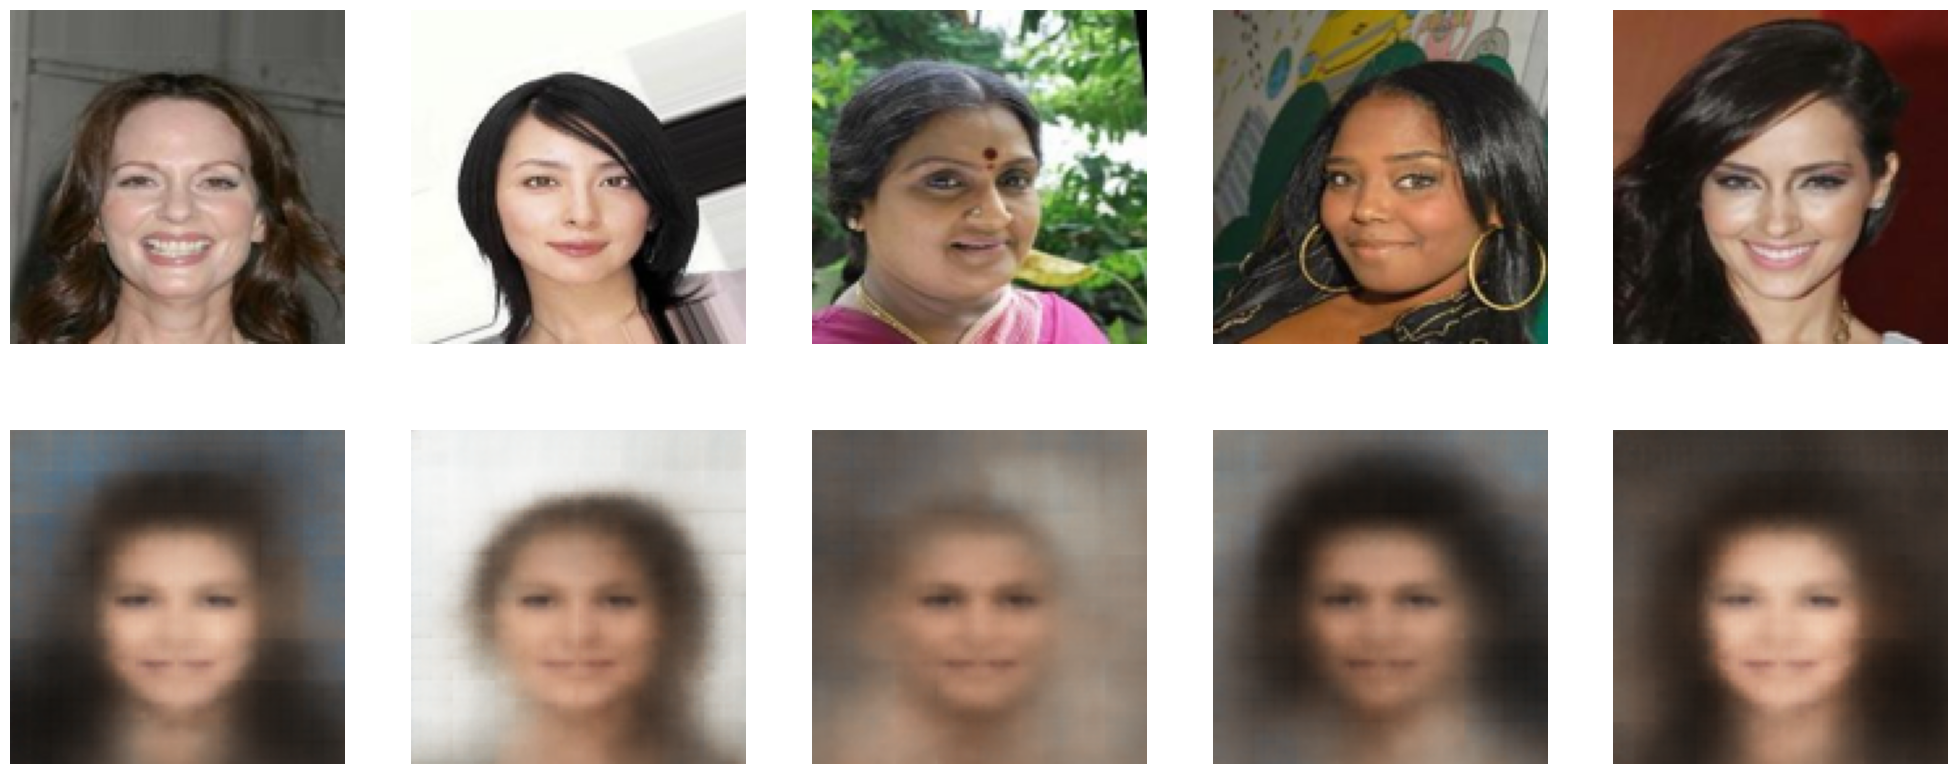

In [8]:
from utils import display
real = next(test.stream(vae.NORM, 5))[1]
fake = vae.model.predict(real, verbose=0)
display(*map(vae.DENORM, (real, fake)))

###  Wasserstein GAN with Gradient Penalty 

Our second baseline is the Wasserstein GAN with Gradient Penalty ([Arjovsky et al., 2017](https://arxiv.org/abs/1701.07875)). This model follows the Generative Adversarial Networks paradigm (GANs) and uses a generator module ($\mathcal{G}: \mathbb{R}^{d_\text{wgan}}\to\mathbb{R}^{h\times w \times 3}$) to reconstruct an arbitrary image from a latent space of dimension $d_\text{gan}$, and a discriminator module ($\mathcal{C}:\mathbb{R}^{h\times w \times 3}\to[0,1]$) to distinguish samples of the real training distribution from the samples generated by $\mathcal{G}$. The Wasserstein GAN with Gradient Penalty introduced two modifications from the standard GAN to facilitate the optimization of the network. Commonly, GANs suffered from convergence issues and the exploding gradient problem. The WGAN proposed a new loss function (see implementation at [gan.py](models/gan.py)) using the Wasserstein distance proved to derive into smoother gradients - thus solving the collapsing issues -, and a regularization method (named Gradient Penalty) to penalize gradients and stabilize the process of loss minimization.


The class `GAN` (implemented in [gan.py](models/gan.py)) builds and trains the adversarial model with the specific callbacks and metrics. This class accepts the following arguments:

- `img_size`: Image size. For these exercises, we selected RGB images with resolution $128\times 128$.
- `hidden_size`: Dimension of the latent space.
- `pool`: Type of pooling ot use in the generator and discriminator. If `strides`, it uses convolutions with double-strides. If `dilation` it uses dilated convolutions followed by max-pooling or up-sampling. By default `strides`.
- `residual`: Whether to use residual blocks. By default it uses standard convolutional blocks.
- `critic_steps`: Number of steps training the discriminator before optimizing the generator.
- `gp_weight`: Optimization hyperparameter in the gradient penalty.

In [5]:
wgan = GAN(CelebADataset.IMG_SIZE, hidden_size = 128, pool='strides', residual=False, critic_steps=3, gp_weight=10)

To train the GAN model the smae arguments as explained in the VAE implementation must be used:

In [6]:
wgan_history = wgan.train(train, val, test, path='results/wgan', batch_size=20, epochs=10)

Found 162770 files belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a1f3cd652d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a1f3cd652d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Found 19867 files belonging to 1 classes.


inception:   0%|          | 0/50 [00:00<?, ?it/s]2024-05-24 16:06:13.976071: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


Epoch 1/10


2024-05-24 16:06:25.261341: I external/local_xla/xla/service/service.cc:168] XLA service 0x5a3e09d44a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-24 16:06:25.261363: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-24 16:06:25.261367: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-24 16:06:25.267984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716559585.363076  502984 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - ETA: 0s - c_loss: -2.8608 - c_wass_loss: -3.4819 - c_gp: 0.0621 - g_loss: 8.3531 - c_acc: 15.6801 - g_acc: 95.9855

1500/1500 [==============================] - 531s 351ms/step - c_loss: -2.8608 - c_wass_loss: -3.4819 - c_gp: 0.0621 - g_loss: 8.3531 - c_acc: 15.6705 - g_acc: 95.9881 - val_c_acc: 0.0000e+00 - val_g_acc: 100.0000 - fid: 374.6558 - val_fid: 372.9523
Epoch 2/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.7196 - c_wass_loss: -0.7840 - c_gp: 0.0064 - g_loss: 5.6114 - c_acc: 0.9301 - g_acc: 99.3868

1500/1500 [==============================] - 530s 353ms/step - c_loss: -0.7196 - c_wass_loss: -0.7840 - c_gp: 0.0064 - g_loss: 5.6114 - c_acc: 0.9319 - g_acc: 99.3869 - val_c_acc: 0.0000e+00 - val_g_acc: 100.0000 - fid: 402.8370 - val_fid: 400.5402
Epoch 3/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.2087 - c_wass_loss: -1.3187 - c_gp: 0.0110 - g_loss: 3.4947 - c_acc: 15.1255 - g_acc: 91.8309

1500/1500 [==============================] - 528s 352ms/step - c_loss: -1.2087 - c_wass_loss: -1.3187 - c_gp: 0.0110 - g_loss: 3.4947 - c_acc: 15.1356 - g_acc: 91.8189 - val_c_acc: 0.0000e+00 - val_g_acc: 100.0000 - fid: 408.8687 - val_fid: 406.1084
Epoch 4/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.8362 - c_wass_loss: -0.8864 - c_gp: 0.0050 - g_loss: 2.7144 - c_acc: 29.4165 - g_acc: 79.6204

1500/1500 [==============================] - 525s 350ms/step - c_loss: -0.8362 - c_wass_loss: -0.8864 - c_gp: 0.0050 - g_loss: 2.7144 - c_acc: 29.4149 - g_acc: 79.6254 - val_c_acc: 2.2000 - val_g_acc: 100.0000 - fid: 490.2902 - val_fid: 482.3736
Epoch 5/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.9129 - c_wass_loss: -0.9669 - c_gp: 0.0054 - g_loss: 1.4458 - c_acc: 42.9939 - g_acc: 72.4017

1500/1500 [==============================] - 531s 354ms/step - c_loss: -0.9129 - c_wass_loss: -0.9669 - c_gp: 0.0054 - g_loss: 1.4458 - c_acc: 43.0167 - g_acc: 72.3857 - val_c_acc: 100.0000 - val_g_acc: 48.6000 - fid: 502.4674 - val_fid: 498.0322
Epoch 6/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.9461 - c_wass_loss: -1.0052 - c_gp: 0.0059 - g_loss: 0.2246 - c_acc: 66.9077 - g_acc: 54.9823

1500/1500 [==============================] - 534s 356ms/step - c_loss: -0.9461 - c_wass_loss: -1.0052 - c_gp: 0.0059 - g_loss: 0.2246 - c_acc: 66.9147 - g_acc: 54.9793 - val_c_acc: 99.6000 - val_g_acc: 60.4000 - fid: 469.1463 - val_fid: 464.2170
Epoch 7/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.9770 - c_wass_loss: -1.0419 - c_gp: 0.0065 - g_loss: 0.5904 - c_acc: 65.7503 - g_acc: 70.0368

1500/1500 [==============================] - 535s 356ms/step - c_loss: -0.9770 - c_wass_loss: -1.0419 - c_gp: 0.0065 - g_loss: 0.5904 - c_acc: 65.7523 - g_acc: 70.0353 - val_c_acc: 86.6000 - val_g_acc: 96.8000 - fid: 462.3430 - val_fid: 472.8241
Epoch 8/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.2337 - c_wass_loss: -1.3293 - c_gp: 0.0096 - g_loss: 1.8328 - c_acc: 37.8011 - g_acc: 83.6471

1500/1500 [==============================] - 534s 356ms/step - c_loss: -1.2337 - c_wass_loss: -1.3293 - c_gp: 0.0096 - g_loss: 1.8328 - c_acc: 37.7920 - g_acc: 83.6517 - val_c_acc: 0.4000 - val_g_acc: 100.0000 - fid: 456.8448 - val_fid: 454.1087
Epoch 9/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.0129 - c_wass_loss: -1.0739 - c_gp: 0.0061 - g_loss: 2.3282 - c_acc: 23.2813 - g_acc: 91.6023

1500/1500 [==============================] - 528s 352ms/step - c_loss: -1.0129 - c_wass_loss: -1.0739 - c_gp: 0.0061 - g_loss: 2.3282 - c_acc: 23.2863 - g_acc: 91.5991 - val_c_acc: 5.8000 - val_g_acc: 100.0000 - fid: 433.3018 - val_fid: 429.7416
Epoch 10/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.0229 - c_wass_loss: -1.0896 - c_gp: 0.0067 - g_loss: 1.5077 - c_acc: 37.4816 - g_acc: 90.7917

1500/1500 [==============================] - 526s 351ms/step - c_loss: -1.0229 - c_wass_loss: -1.0896 - c_gp: 0.0067 - g_loss: 1.5077 - c_acc: 37.5001 - g_acc: 90.7891 - val_c_acc: 61.4000 - val_g_acc: 100.0000 - fid: 446.2078 - val_fid: 445.7891


In [10]:
plot_history(wgan_history, name=['c_acc', 'g_acc', 'val_c_acc', 'val_g_acc']).update_xaxes(title_text='acc')
plot_history(wgan_history, name='fid')

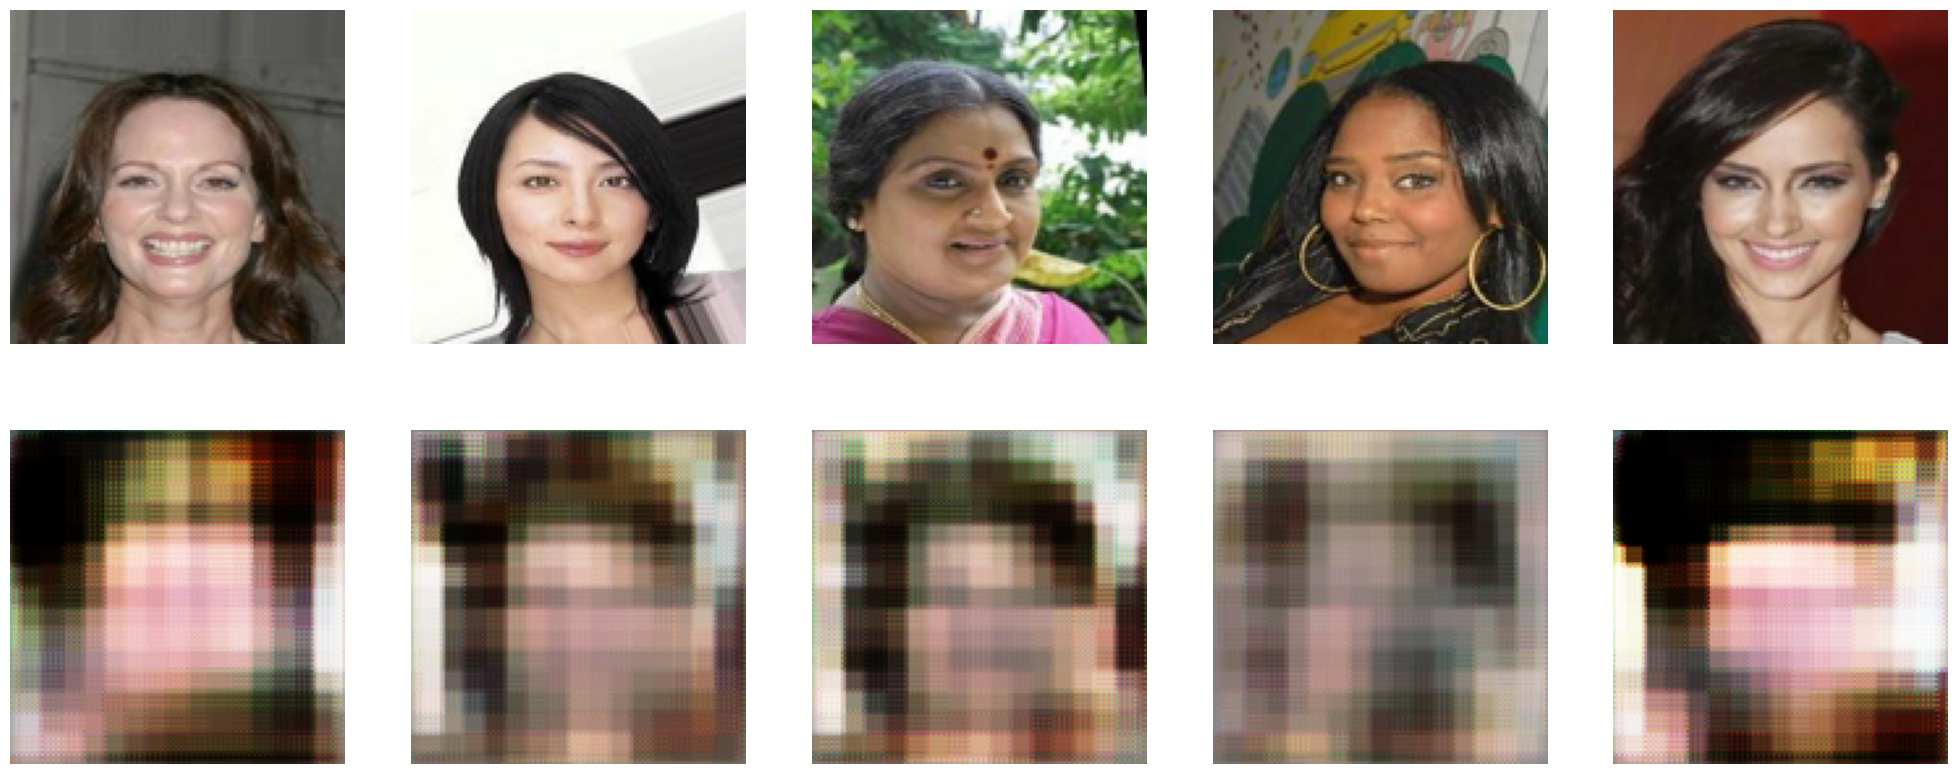

In [21]:
real = next(test.stream(wgan.NORM, 5))[1]
fake = wgan.model(real)
display(*map(wgan.DENORM, (real, fake)))

### Evaluation metrics 

In order to fairly compare the performance of the VAE and WGAN-GP, we used **FID score** ([Chong & Forsyth, 2019](https://arxiv.org/abs/1911.07023)) as evaluation metric, comparing the real with the generated distribution using the activations of the pretrained [Inception-V3](https://keras.io/api/applications/inceptionv3/) ([Szegedy et al., 2015](https://arxiv.org/abs/1512.00567)) with interpolated images at resolution $256\times 256$. Additionally, the different configuration of the VAE were compared with:

1. The reconstruction error (r-loss), measured as the pixel-wise difference between the original and reconstructed images for VAEs.
2. The Kullback–Leibler (KL) divergence, measured as the  discrepancy between the approximate latent space distribution and a prior distribution (in this case a standard normal).


## Experiments and Variations in the Architecture



In the previous demonstration of the generative baselines we limited the size of the latent space to $d_\text{vae} = 200$ and $d_\text{wgan}=128$. In order to test the capacities of the VAE and WGAN-GP models, we performed experiments (1) increasing the dimension of the latent space ($\{128, 256, 512\}$), (2) using residual blocks instead of standard convolutions and  (3) increasing the dilation of the convolutional layers to expand the receptive field of the network. We investigated the potential of incorporating skip connections in the VAE architecture (based on [Ronnenberg et al. (2015)](https://arxiv.org/abs/1505.04597)'s work) and obtained good results in image generation. However, we discarded the modification since it does not improve the model's capacity to learn the original distribution from latent representations. While skip connections enhance reconstruction fidelity, they allow the model to merely replicate the input image, which relegates on a second level the main objective of the VAE (capturing the underlying data distribution and generating novel samples).


To facilitate readibility of this notebook, we do not include the Keras output of each model, but a summary of the performance obtained with each configuration. Similar results can be reproduced followng the [README.md](README.md) file attached with the code.









## Results 


FID scores obtained with VAE, KL divergence and reconstruction error:

| $d_\text{vae}$ | pool         | residual     | train        | val          | test         |  KL      | R       |
|:--------------:|:------------:|:------------:|:------------:|:------------:|:------------:|:--------:|--------:|
| 128            | *strides*    | -            | 212.66       | 215.97       | 209.84       | 0.027    | 10.05   |
| 256            | *strides*    | -            | 228.96       | 232.17       | 225.65       | 0.027    | 9.20    |
| 512            | *strides*    | -            | 209.34       | 212.37       | 206.34       | 0.028    | 9.17    |
| 512            | *dilation*   | -            | 339.24       | 341.11       | 339.18       | 0.031    | 8.62    |
| 512            | *strides*    | +            | 205.71       | 219.34       | 204.51       | 0.028    | 8.75    |
| 512            | *dilation*   | +            | 231.04       | 232.85       | 228.05       | 0.026    | 9.18    |



FID scores obtained with WGAN-GP:

| $d_\text{wgan}$ | pool         | residual     | train        | val          | test         |
|:---------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| 128             | *strides*    | -            | 406.35       | 406.11       | 405.09       |
| 256             | *strides*    | -            | 500.25       | 502.93       | 502.32       |
| 512             | *strides*    | -            | 485.07       | 486.74       | 485.32       |
| 512             | *dilation*   | -            | 477.84       | 479.42       | 478.58       |
| 512             | *strides*    | +            |              |              |              |
| 512             | *dilation*   | +            | 404.86       | 405.10       | 404.43       |


In terms of FID scores, we see that the VAE clearly outperforms the WGAN-GP when comparing the real with the generated distribution. Taking into account the architecture of each model and the training benchmark used to obtain these results, it is straightforward to assume that the VAE is fed with more information about the real distribution than the WGAN-GP, which uses a small convolution decoder module to completely reconstruct data from a Gaussian latent space of dimension $d_\text{wgan}$. Theretically, GANs have demonstrated to outperform VAE-based architectures in image generation ([Karras et al. (2020)](https://arxiv.org/abs/1912.04958), [Shaham et al., (2019)](https://arxiv.org/abs/1905.01164)), however, due to our computational resources (training on images with low resolution and during less than 100 epochs), we expect that our training configuration does not exploit all the potential of the GAN-based architecture and it is not able to reconstruct the real distribution -- although with hyperparameter tunning and exhaustive training will probably reach the VAE performance.

By analyzing the KL divergence (KL) and reconstruction loss (R) metrics in the VAE and FID score in the WGAN-GP we see that there is not a significative difference between different configurations: all subsets reach similar results (thus we are guaranteed that the model is not overfitting the train set) and increasing the latent space does not seem to derive into better quantitative metrics. 

The next cell shows an example from the evaluation set and the corresponding generation with each model and configuration (the first row displays the results with the VAE and the second row the images generated with the WGAN-GP).

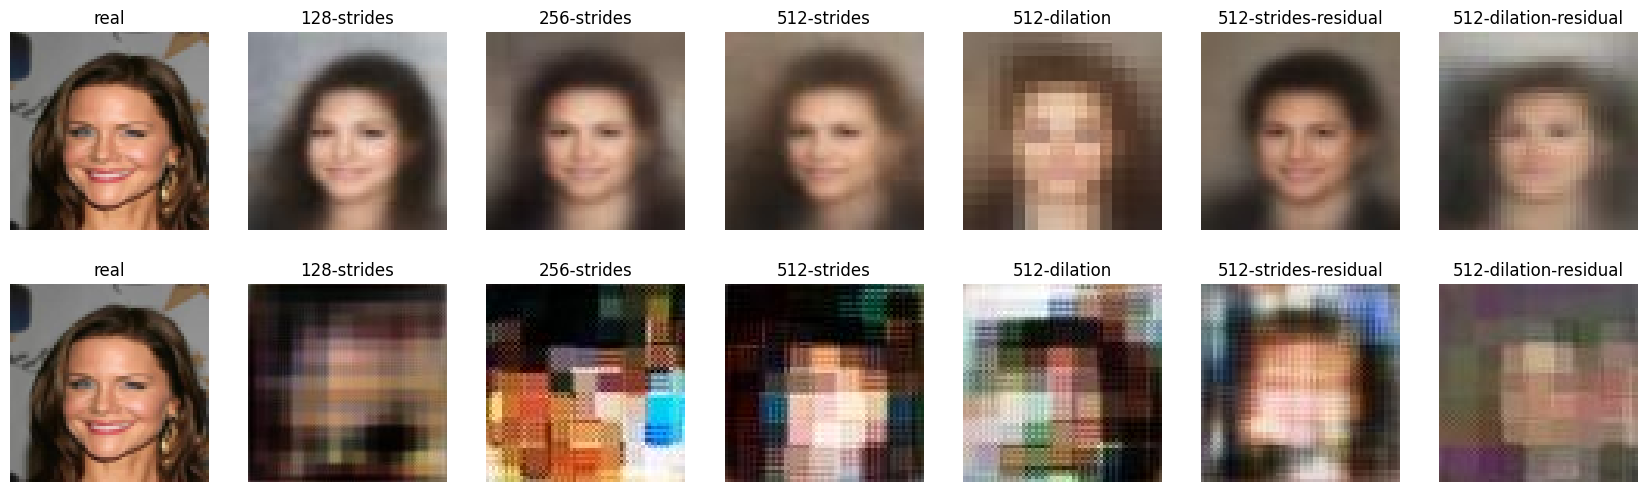

In [56]:
import matplotlib.pyplot as plt 
from PIL import Image 

img_file = '182641'
fig, ax = plt.subplots(2, 7, figsize=(3*7, 6))
gold = Image.open('archive/test/182641.jpg').resize((64, 64))
vae_128_strides = Image.open('results/vae_128_strides/test-preds/182641.jpg')
vae_256_strides = Image.open('results/vae_256_strides/test-preds/182641.jpg')
vae_512_strides = Image.open('results/vae_512_strides/test-preds/182641.jpg')
vae_512_dilation = Image.open('results/vae_512_dilation/test-preds/182641.jpg')
vae_512_strides_residual = Image.open('results/vae_512_strides_residual/test-preds/182641.jpg')
vae_512_dilation_residual = Image.open('results/vae_512_dilation_residual/test-preds/182641.jpg')


wgan_128_strides = Image.open('results/wgan_128_strides/test-preds/182641.jpg')
wgan_256_strides = Image.open('results/wgan_256_strides/test-preds/182641.jpg')
wgan_512_strides = Image.open('results/wgan_512_strides/test-preds/182641.jpg')
wgan_512_dilation = Image.open('results/wgan_512_dilation/test-preds/182641.jpg')
wgan_512_strides_residual = Image.open('results/wgan_512_strides_residual/test-preds/182641.jpg')
wgan_512_dilation_residual = Image.open('results/wgan_512_dilation_residual/test-preds/182641.jpg')

ax[0,0].imshow(gold); ax[0,0].set_title('real'); ax[0,0].set_axis_off()
ax[0,1].imshow(vae_128_strides); ax[0,1].set_title('128-strides'); ax[0,1].set_axis_off()
ax[0,2].imshow(vae_256_strides); ax[0,2].set_title('256-strides'); ax[0,2].set_axis_off()
ax[0,3].imshow(vae_512_strides); ax[0,3].set_title('512-strides'); ax[0,3].set_axis_off()
ax[0,4].imshow(vae_512_dilation); ax[0,4].set_title('512-dilation'); ax[0,4].set_axis_off()
ax[0,5].imshow(vae_512_strides_residual); ax[0,5].set_title('512-strides-residual'); ax[0,5].set_axis_off()
ax[0,6].imshow(vae_512_dilation_residual); ax[0,6].set_title('512-dilation-residual'); ax[0,6].set_axis_off()

ax[1,0].imshow(gold); ax[1,0].set_title('real'); ax[1,0].set_axis_off()
ax[1,1].imshow(wgan_128_strides); ax[1,1].set_title('128-strides'); ax[1,1].set_axis_off()
ax[1,2].imshow(wgan_256_strides); ax[1,2].set_title('256-strides'); ax[1,2].set_axis_off()
ax[1,3].imshow(wgan_512_strides); ax[1,3].set_title('512-strides'); ax[1,3].set_axis_off()
ax[1,4].imshow(wgan_512_dilation); ax[1,4].set_title('512-dilation'); ax[1,4].set_axis_off()
ax[1,5].imshow(wgan_512_strides_residual); ax[1,5].set_title('512-strides-residual'); ax[1,5].set_axis_off()
ax[1,6].imshow(wgan_512_dilation_residual); ax[1,6].set_title('512-dilation-residual'); ax[1,6].set_axis_off()

The example above clearly evidences the performance of the VAE against the WGAN-GP. The VAE does not recover fine-gradined details, resulting in a blur face image, but at least is able to reconstruct facial features (such as eyes, hair, mouse and nose). The WGAN-GP instead is only able to reconstruct a circular shape in the middle of the image (resembling the face of the person), but it is not able to generate facial elements such as eyes or nose. As mentioned before, the WGAN-GP is limited in this case by the training time and data resources: we might expect better results increasing the network dimension and providing a large period of training time.

In the images generated with the VAE we see more accurate results with strides than with dilated convolutions. Our explanation of this behavior relies on how the dilated convolution works on images with high-resolution, which was intended to expand the perceptive field of each convolution by skipping near pixels that do not provide meaningful information when summarizing local features. In images with high-resolution, where nearby pixels are almost the same, the dilated convolution helps speeding the training time by skipping some steps where no information is provided (first convolutional levels): however, in images with low resolution (our case) skipping pixels at lower levels might lead to ignoring fine-gradined details, such as textures, resulting in blurred imges (as we see in the example).

## Exploring the latent space 

In this section we explored the latent space obtained with each model (VAE and WGAN-GP) and experimented with the generation of new images from the latent space.  With the aim of grouping the different projections of the input images, we relied on the binary annotations provided in the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) about different characteristics of the person recorded in each image. 

The [list_attr_celeba.csv](archive/list_attr_celeba.csv) file contains binary features of each image (such as gender, hairstyle, eyeglasses, age, facial characteristics, etc.). In order to evaluate the VAE latent space we can classify some images in different categories (for instance, by hairstyle) and project their embeddings into a representable space (e.g. 2 or 3 dimensions). For this purpose, we used LDA  ([Fisher, 1986](https://en.wikipedia.org/wiki/Linear_discriminant_analysis#References)) to project the set of selected embeddings of dimension $d_h^\text{(vae)}$ and represented them in a 3-dimensional space.

In [3]:
info = pd.read_csv('archive/list_attr_celeba.csv', index_col=0)
partition = pd.read_csv('archive/list_eval_partition.csv', index_col=0)
info = info.join(partition)
info.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'partition'],
      dtype='object')

### Latent representations from VAE

The next cell loads the pretrained weights of the VAE generator with $d_h=512$ and selects 200 instances for each category (`Bald`, `Black_Hair`, `Blond_hair`, `Brown Hair`, `Gray_Hair`). Then, obtains the latent vectors of each image and displays them in a 3-dimensional space (projected with [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)):

In [ ]:
vae = VAE(CelebADataset.IMG_SIZE, hidden_size=512, pool='strides', residual=False)
vae.model.load_weights('results/vae_512_strides/model.h5')

In [60]:
categories = ['Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']
LIMIT = 200
images, labels = [], []
for c in categories:
    selection = info[info[c] == 1].copy()
    # drop 
    for other in categories:
        if c != other:
            selection = selection[selection[other] == -1]
    selection = selection[:LIMIT]
    images += [f'archive/{PARTITIONS[partition]}/{file}' for file, partition in zip(selection.index, selection.partition)]
    labels += [c for _ in range(LIMIT)] 
embed = vae.latent(images)

lda = LDA(n_components=3)
proj = lda.fit_transform(np.stack(embed), np.array(labels))
fig = plot_embeds(proj, categories)
fig.show()

This visualization allows us to qualitatively assess the organization of the latent space of the VAE model when introducing images with different characteristics. We see that some groups  like `Bald` with `Gray Hair` look more "intermixed" than others (for instance, the `Bald` group is completly separated from `Black_Hair` and `Brown_Hair`). This is an indication that latent vectors of bald people or people with gray hair are less discriminable, so we can expect a similar generated image when the input is bald or has gray hair. Some outliers of the `Blond_Hair` group overlap with `Bald` and `Gray_Hair`, indicating again that for the VAE is more difficult to discriminate betwen these characteristics than with respect to others (such as `Brown_Hair` and `Black_Hair`). This representation matches with our intuition that samples with dark hair are more distinguishable (in terms of average pixel difference) from samples with light hair and that samples with light hair or no hair tend to result in a similar compression. 

Other observation is that groups like `Blond_Hair`, `Brown_Hair` and `Black_Hair` have more outliers in their projected distribution than others (such as `Bald`). This might suggest that those groups with more outliers contain more data samples that the VAE encoder better discriminates. Again, this behavior matches with our intuition of diversity in persons with no hair against persons with hair: we expect less visual variability in images of celebrities with no hair than celebrities with hair.

In the next cell we explore what happens if we generate the artificial distribution from latent vectors instead of the real input images. By selecting 7 different images of bald celebrities and obtaining their corresponding generated image and latent vector, we can compute the mean of the latent vectors (expecting them to be representative enough to estimate the centroid of the cluster of bald people in the hidden space) and see if the decoder is able to reproduce an image with similar visual characteristics. The output below gives us a hint of how the VAE is organizing the different images in the latent space.

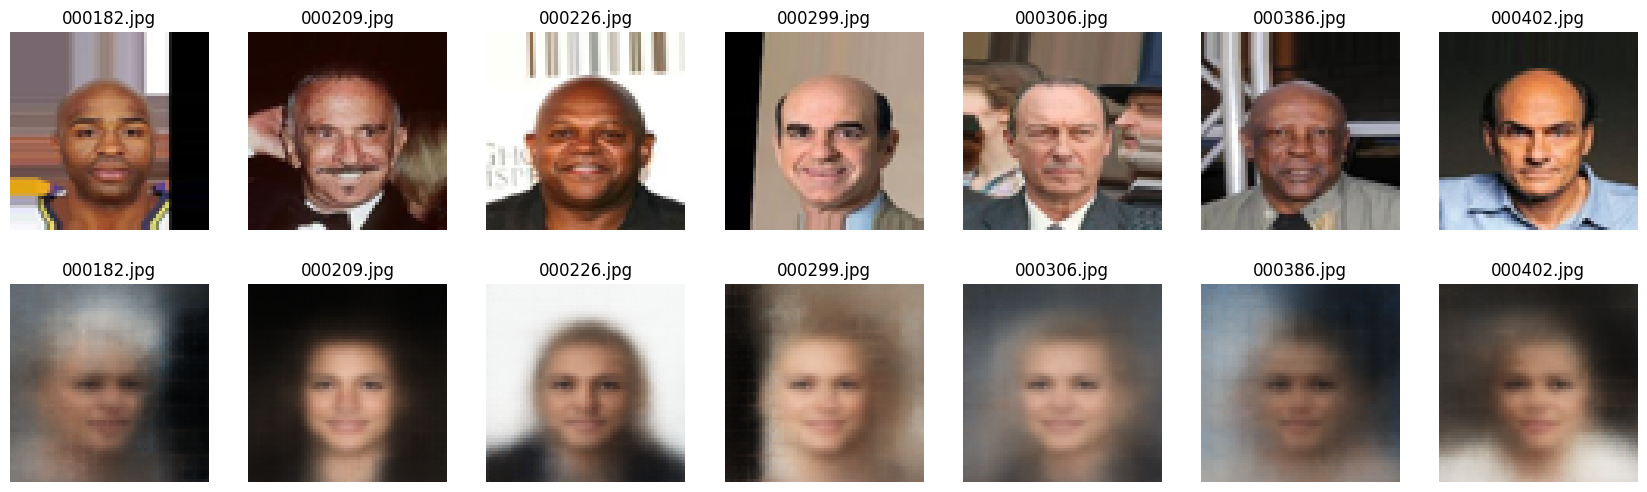

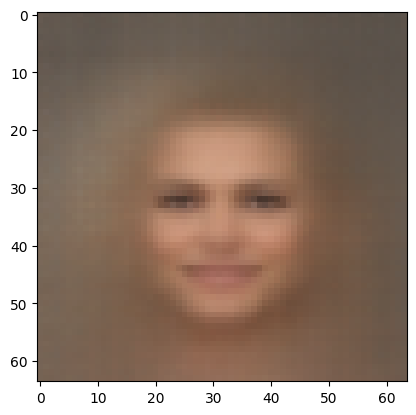

In [21]:
get_paths = lambda df: [f'archive/{PARTITIONS[part]}/{file}' for file, part in zip(df.index, df.partition)]
load_img = lambda path: np.array(Image.open(path).resize(CelebADataset.IMG_SIZE[:2]))

balds = get_paths(info[(info.Bald == 1)])[5:12]
fig, ax = plt.subplots(2, 7, figsize=(3*7, 6))
fakes = vae.generate(balds)
# get the latent vectors of bald people
latent = vae.latent(balds)
fake_mean = vae.from_latent([np.stack(latent).mean(0)]) # pass the mean to the decoder

for i, (path, fake) in enumerate(zip(balds, fakes)):
    ax[0,i].imshow(load_img(path))
    ax[0,i].set_title(path.split('/')[-1])
    ax[0,i].set_axis_off()
    ax[0,i].set_axis_off()
    ax[1,i].imshow(fake)
    ax[1,i].set_title(path.split('/')[-1])
    ax[1,i].set_axis_off()
    ax[1,i].set_axis_off()
plt.show()
plt.imshow(fake_mean[0])

Similarly, we can compute the mean latent vector of people with dark wavy hair.  By repeating the same experiment but filtering those images with wavy and black hair, we see that the mean generated image has not changed facial features with respect to the previous one (since it is still the mean of multiple faces), but the decoder is able to recover the dark hair characteristic (instead of trying to reproduce a bald person).

from-latent: 0it [00:00, ?it/s]

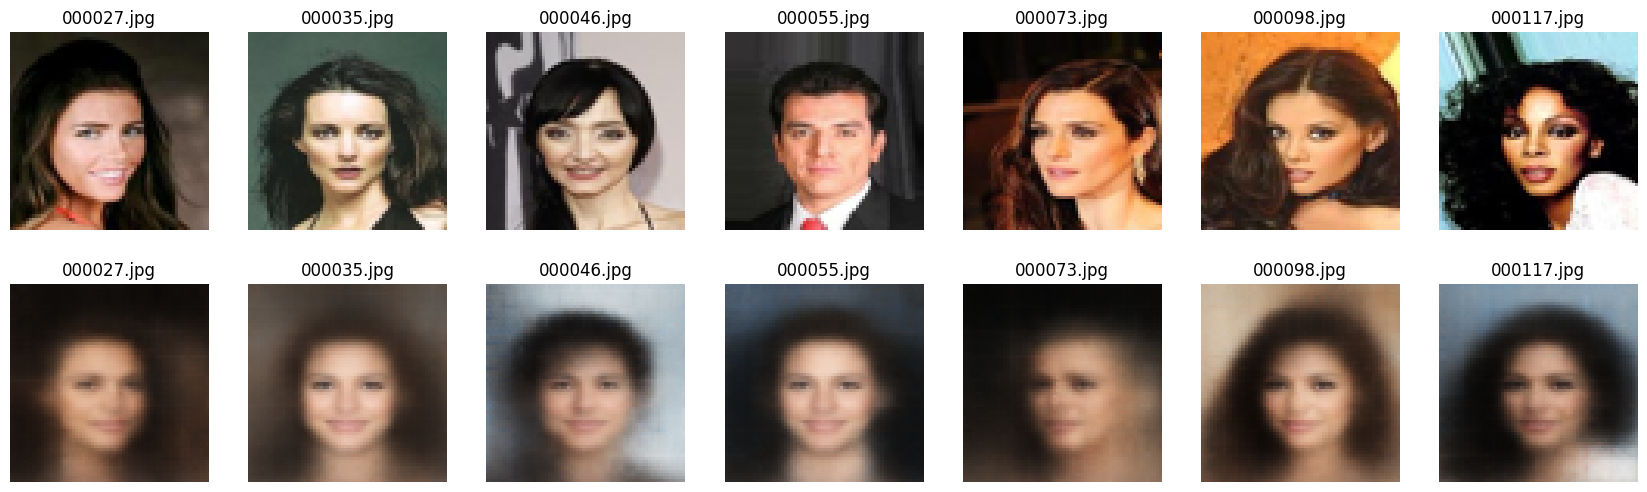

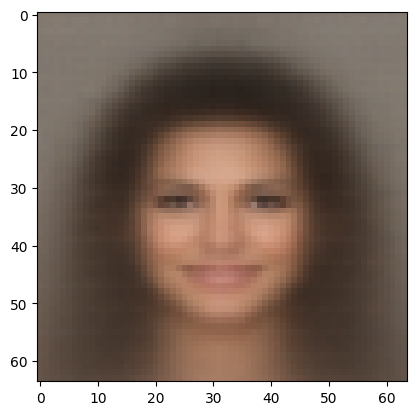

In [38]:
blonds = get_paths(info[(info.Black_Hair == 1) & (info.Wavy_Hair == 1)])
fig, ax = plt.subplots(2, 7, figsize=(3*7, 6))
fakes = vae.generate(blonds[:7])
latent = vae.latent(blonds)
fake_mean = vae.from_latent([np.stack(latent).mean(0)]) # pass the mean to the decoder

for i, (path, fake) in enumerate(zip(blonds, fakes)):
    ax[0,i].imshow(load_img(path))
    ax[0,i].set_title(path.split('/')[-1])
    ax[0,i].set_axis_off()
    ax[0,i].set_axis_off()
    ax[1,i].imshow(fake)
    ax[1,i].set_title(path.split('/')[-1])
    ax[1,i].set_axis_off()
    ax[1,i].set_axis_off()
plt.show()
plt.imshow(fake_mean[0])

### Latent representations from WGAN-GP

The analysis of latent representations of the WGAn-GP is not straightforward as the compressed representations of the VAE. Since the VAE is trained one-to-one, it has a latent represention for any arbitrary input image, so we can establish a relation between real images that we can analyze and the corresponding representation in the VAE. The WGAN-GP generator was optimized to generate real images from a $d_\text{wgan}$-dimensional Gaussian distribution with zeo mean and standard deviation equals to 1. Thus, when sampling latent vectors with this distribution we expect to reconstruct the most realistic images that the model was able to learn during the training process. We can experiment with the latent space of the WGAN-GP sampling latent vectors from altered normal distributions:

1. Instead of sampling with $\sigma=1$, if we reduce the $\sigma$ to 0.5 and maintain $\mu=0$, we are theoretically retrieving images closer to the average (i.e. images that are more generated more times by the GAN).
2. Instead of sampling with $\mu=0$ and $\sigma=1$, we can slightly shift the distribution by sampling latent vectors from a Gaussian with $\mu=1$ or $\mu=-1$ and $\sigma=0.5$ (the standard deviation is reduced to ensure that we are sampling displaced vectors).
3. Replacing the Gaussian distribution by a uniform distribution. By uniformatly sampling vectors in the range $[-2, 2]$ we can see the samples that uniformly cover almost all the latent space, and see possible anomalies when extracting some vectors.

In [1]:
import tensorflow as tf 
from models import GAN
import matplotlib.pyplot as plt 
from data import CelebADataset
wgan = GAN(CelebADataset.IMG_SIZE, hidden_size=128, pool='strides', residual=False, critic_steps=3, gp_weight=10)
wgan.model.load_weights('results/wgan_128_strides/checkpoint/checkpoint.ckpt')

2024-05-26 21:23:36.616635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 21:23:36.649329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 21:23:36.649357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 21:23:36.650390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 21:23:36.656017: I tensorflow/core/platform/cpu_feature_guar

2024-05-26 21:23:37.303115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-26 21:23:38.430634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-05-26 21:23:38.431144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1280 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


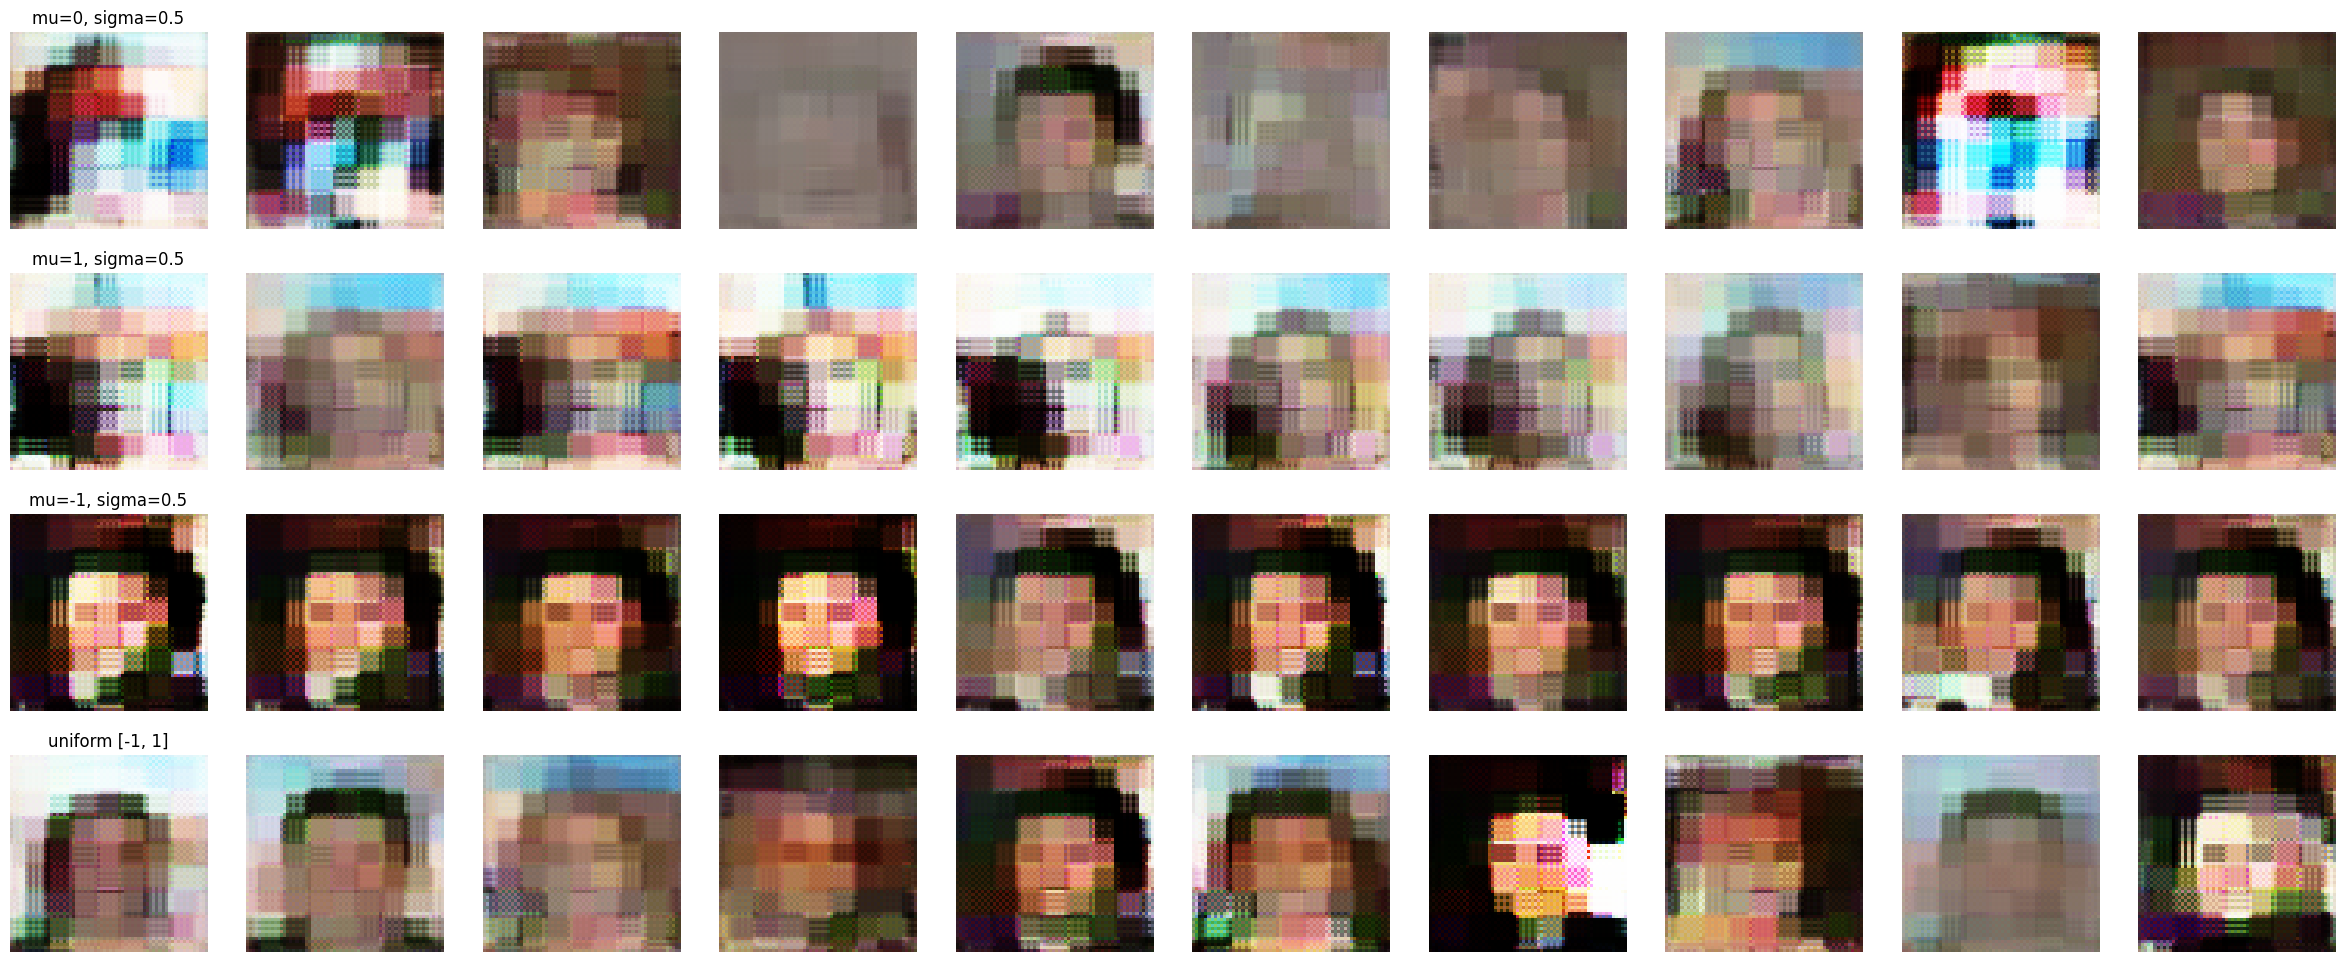

In [13]:
fig, ax = plt.subplots(4, 10, figsize=(10*3, 3*4))

# sample with sigma = 0.5
latent = tf.random.normal((10, 128), stddev=0.5)
fakes = wgan.generate(latent)
ax[0,0].set_title('mu=0, sigma=0.5')
for i, fake in enumerate(fakes):
    ax[0,i].imshow(fake); ax[0,i].set_axis_off()
    
# sample with mean = 1 and sigma = 0.5
latent = tf.random.normal((10, 128), mean=1, stddev=0.5)
fakes = wgan.generate(latent)
ax[1,0].set_title('mu=1, sigma=0.5')
for i, fake in enumerate(fakes):
    ax[1,i].imshow(fake); ax[1,i].set_axis_off()
    
# sample with mean = -1 and sigma = 0.5
latent = tf.random.normal((10, 128), mean=-1, stddev=0.5)
fakes = wgan.generate(latent)
ax[2,0].set_title('mu=-1, sigma=0.5')
for i, fake in enumerate(fakes):
    ax[2,i].imshow(fake); ax[2,i].set_axis_off()
    
# sample with uniform
latent = tf.random.uniform((10, 128), minval=-2, maxval=2)
fakes = wgan.generate(latent)
ax[3,0].set_title('uniform [-1, 1]')
for i, fake in enumerate(fakes):
    ax[3,i].imshow(fake); ax[3,i].set_axis_off()

We can see some patterns in the images generated with different distributions. While sampling from $\mathcal{N}(0, 0.5)$ or $\mathcal{N}(1, 0.5)$  seems lead to latent vectors that generate lighter background and pale skin, sampling from  $\mathcal{N}(-1, 0.5)$ retrieves reconstructions with dark background and dark hair.

In the next cell we make a grid of normal distribution varying the mean from $-1.5$ to $1$ and sample 10 latent vectors. The visualization shows that vectors sampled from lower values ($\mu<0$) correspond to images with dark background and dark hair, while latent vectors sampled from higher values ($\mu > 0$) reconstruct faces with pale skin and lighter background. This analysis might give us an intuition that the WGAN-GP also organizes the latent space to reconstruct dark and light images, keeping negative values for faces with dark hair and higher values for images with pale skin and a noisy background.

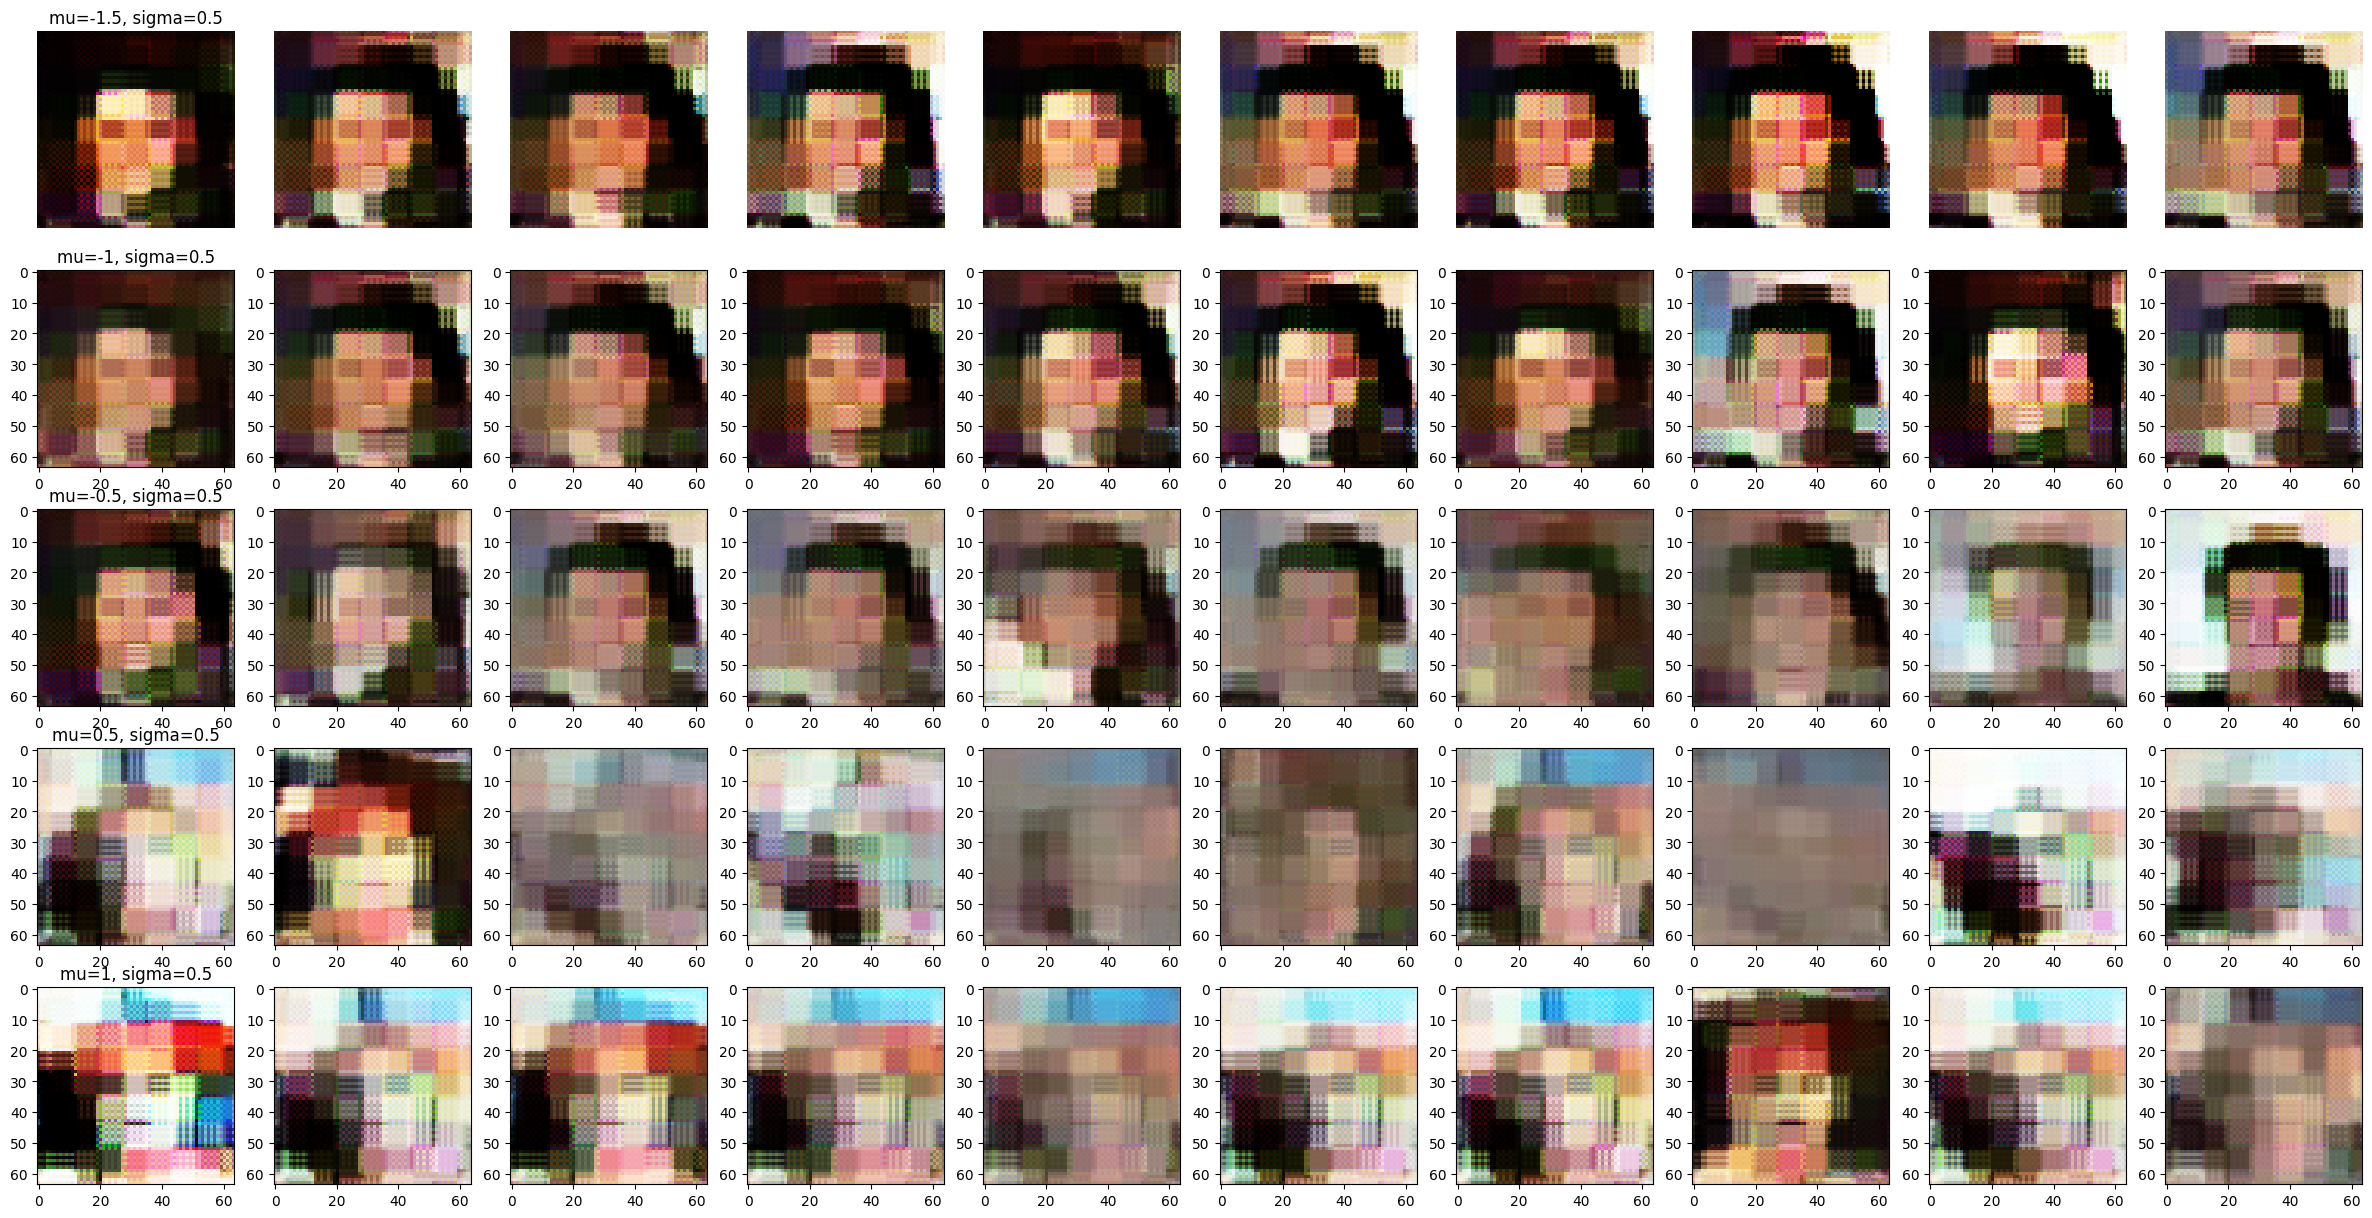

In [18]:
fig, ax = plt.subplots(5, 10, figsize=(10*3, 3*5))

for i, mean in enumerate([-1.5, -1, -0.5, 0.5, 1]):
    latent = tf.random.normal((10, 128), mean=mean, stddev=0.5)
    fakes = wgan.generate(latent)
    ax[i,0].set_title(f'mu={mean}, sigma=0.5')
    for j, fake in enumerate(fakes):
        ax[i,j].imshow(fake); ax[0,j].set_axis_off()
    

## Comparative Analysis


By exploring the VAE and WGAN-GP models with  different latent space dimensions ($\{128, 256, and 512\}$) and incorporating residual connections and dilated convolutions, we have assessed and compared their performance in the quality of reconstructed distribution from a latent space representation. In our experiments, the VAE has obtained better results in terms of quantitative metrics (FID score) and qualitative analysis (manually comparison of generated images), but we have pointed out the limitations of the WGAN-GP in our computational benchmark and our expectations (backed up by previous studies) to reach a similar performance with a more exhausitve training. 

The main findings in this work aim to highlight the strenghts of the VAE in a limitated data scope and shed light to the power of latent representations obtained with deep neural networks for image processing. 

### Analysis of the Variational AutoEncoder (VAE)

The results obtained in the VAE demonstrate that increasing the dimension of the latent space does not scale in a better quantitative performance (lower FID score), but, as we see in our qualitative analysis, using a small latent space $d_\text{vae}=128$ is sufficient to generate accurate samples that resemble the real distribution. The incorporation of residual connections is shown to further enhance the reconstruction quality, while the use of dilated convolutions does not benefit in our benchmark (where the image resolution is not enough to capture fine-grained detailes when skipping nearby pixels). Theoretically, the performance of VAE should improve with larger dimensionality ($d_\text{vae}\in [256, 512]$). However, our results show that more fidelity is maintained when using smaller hidden sizes. We must remark that our models have been subject to many computational limitations (not enough training time, low-resolution images, not using data augmentation, etc.) and the performance could be improved by extending the training capabilities and increasing the dimension of the model. For this case, using a low resolution, the VAE with $d_\text{vae}=128$ is enough to accurately recover the main characteristics of the real image dataset. 

### Analysis of the WGAN with Gradient Penalty

One of the main disadvantages of the auto-encoders is that they can struggle when generating different images and always require an input based on the real distribution (e.g. a real image fed to the encoder or a latent vector estimated from the real distribution to fed the decoder). Since the VAE is optimized by learning one-to-one compression, it will always produce images that the encoder has seen or that have mixed characteristics. The WGAN instead learns the real distribution from zero (an it is more robust to data variations and optimization issues) and it has been demonstrated to reconstruct more realistic images (since it is trained by confronting a generator against a discriminator) and produce more diversity than VAEs (since VAEs are optimized to exactly reconstructing the corresponding input image).

Although the state of the art in image generation is constituted by GANs (and, recently, Stable Diffusion models), our limitations in computational resources hinders the attainment of such high-quality outcomes, making it challenging to fully assess their superiority over VAEs in our domain and application. GANs are notoriously harder to train due to potential inestabilities (such as collapse or gradient explosion) than VAEs. The Gradient Penalty alleviates this problem but the makes the model more sensitive to hyperpareemeter selection or training resources. 

Our results show a slight improvement when increasing the dimension of the latent space in GANs, which differs from the behavior obtained with the VAE. This is largely due to the technique of gradient penalty, which stabilizes the gradient and addresses issues of explosion or inestability commonly seen in models with more parameters. Instead, the VAE lacks of  this stabilization technique, leading to a harder optimization of the network (aggravated with small batch sizes and constant learning rate) and less realistic generated samples. 



## Conclusion

This work highlights the strengths and weaknesses of Variational AutoEncoder (VAE) and Wasserstein GAN with Gradient Penalty (WGAN-GP) in a practical case using the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). It also conducts an exhaustive analysis of the latent space of each model, shedding light on how convolutional neural networks are able to summarise and compress visual features. As part of the experimental process, variations were implemented in each architecture and the final results were reported using the FID score. The VAE obtained satisfactory results, while the WGAN-GP failed to reconstruct the main features of the real images. Although GANs is the state-of-the-art for image generation, in certain scenarios, VAEs may offer a more efficient alternative. In particular, VAEs have been observed to exhibit superior generalization capabilities compared to GANs, particularly when limited computational resources are available. This makes them a more viable option in certain contexts. 